In [19]:
#import lib

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

# for imp data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from IPython import display
%config InlineBackend.figure_format = 'svg'

In [20]:
device = torch.device('mps')

In [21]:
# transform = T.Compose([ T.ToTensor(),
#                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229,0.224,0.225])
#                       ])
# trainset = torchvision.datasets.STL10(root='./data',download=True,split='train',transform=transform)
# testset = torchvision.datasets.STL10(root='./data',download=True,split='test',transform=transform)



# #transform to dataloaders
# batchsize=32
# train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
# test_loader = DataLoader(testset, batch_size=256)


In [22]:
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import os
import shutil

# Assuming you have a directory structure like:
# normal/All_Data/
# ├── with_pollution
# └── without_pollution

# Define the source directory and target directories for train and test sets
source_dir = 'normal/All_Data'
train_dir = 'normal/Train_dir'
test_dir = 'normal/Test_dir'

# Function to create train/test split for each class
def train_test_split_class(source, train, test, test_size=0.2):
    # Ensure the target directories exist
    os.makedirs(train, exist_ok=True)
    os.makedirs(test, exist_ok=True)
    
    # Get all class directories
    classes = [d for d in os.listdir(source) if os.path.isdir(os.path.join(source, d))]
    
    for cls in classes:
        # Paths for source class, train class, and test class
        class_source_dir = os.path.join(source, cls)
        class_train_dir = os.path.join(train, cls)
        class_test_dir = os.path.join(test, cls)
        
        # Ensure the class directories in train and test exist
        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)
        
        # List all images in the source class directory
        all_images = [f for f in os.listdir(class_source_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
        
        # Split the images into train and test
        train_images, test_images = train_test_split(all_images, test_size=test_size, random_state=42)
        
        # Function to copy images to target directories
        def copy_files(files, source, target):
            for file in files:
                shutil.copy(os.path.join(source, file), os.path.join(target, file))
        
        # Copy the images to the respective class directories in train and test
        copy_files(train_images, class_source_dir, class_train_dir)
        copy_files(test_images, class_source_dir, class_test_dir)

# Now perform the split
train_test_split_class(source_dir, train_dir, test_dir, test_size=0.2)

# At this point, your Train_dir and Test_dir will have the same structure as All_Data,
# but with the files split for training and testing.

# Now you can create the ImageFolder instances and the DataLoader instances as before




transform = T.Compose([
    T.Resize(256),                   # Resize the image to 256x256 pixels
    T.CenterCrop(224),               # Crop the center 224x224 pixels of the image
    T.ToTensor(),                    # Convert the image to a PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using the ImageNet mean and std
                std=[0.229, 0.224, 0.225])
])

# Create the ImageFolder instances with transformations
trainset = ImageFolder(root=train_dir, transform=transform)
testset = ImageFolder(root=test_dir, transform=transform)

# Define the DataLoader instances
batch_size = 16
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size)


In [23]:
# #check shape of data
# print('Data shapes (train/test)')
# print(trainset.data.shape)
# print(testset.data.shape)

# #and the range of pixel intensity values
# print('\n Data value range:')
# print((np.min(trainset.data),np.max(trainset.data)))

# # the unique categories
# print('\nData categories:')
# print(trainset.classes)

# # trainset testset train_loader




In [24]:
print('Number of training images:', len(trainset))
print('Number of testing images:', len(testset))
print('\nData categories:')


Number of training images: 560
Number of testing images: 140

Data categories:


In [25]:
#but
X,y = next(iter(train_loader))
print(trainset.classes)

print('Data shapes(train/test): ')
print(X.data.shape)

# and the range of pixel intensity values
print('\nData value range:')
print((torch.min(X.data),torch.max(X.data)))



['WithPollution', 'WithoutPollution']
Data shapes(train/test): 
torch.Size([16, 3, 224, 224])

Data value range:
(tensor(-2.1179), tensor(2.6400))


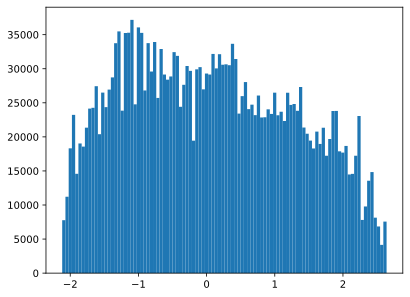

In [26]:
#histogram of the data
plt.hist(X.data.numpy().flatten(),100);

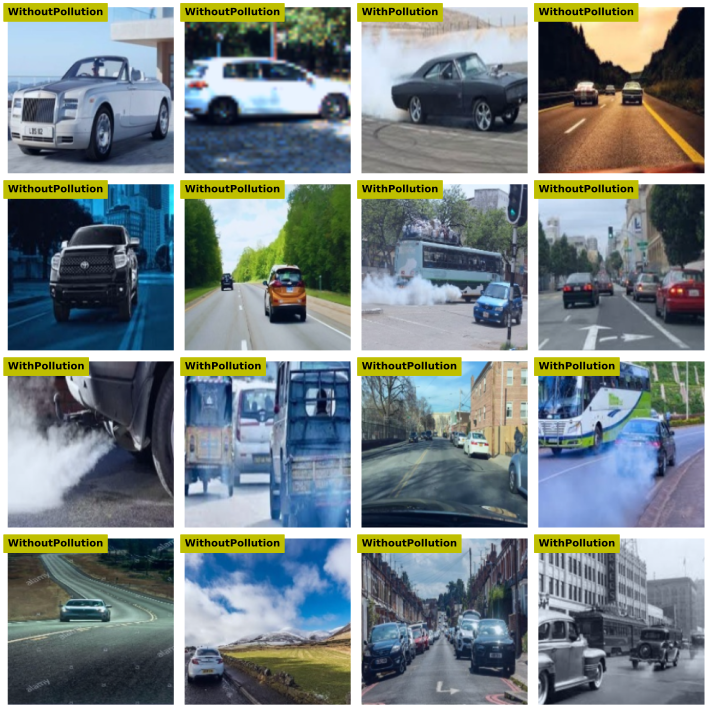

In [27]:
fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):
    #extract that image (need to transpose it bact to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic-np.min(pic) #undo normalization
    pic = pic/np.max(pic)

    #and its label
    label = trainset.classes[y[i]]

    # and show
    ax.imshow(pic)
    ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

# import and inspect the resnet model

In [28]:
resnet = torchvision.models.resnet152(pretrained=True)

In [29]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
from torchsummary import summary
summary(resnet.to(device),(3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 122, 122]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 122, 122]        128
├─ReLU: 1-3                              [-1, 64, 122, 122]        --
├─MaxPool2d: 1-4                         [-1, 64, 61, 61]          --
├─Sequential: 1-5                        [-1, 256, 61, 61]         --
|    └─Bottleneck: 2-1                   [-1, 256, 61, 61]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 61, 61]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 61, 61]          128
|    |    └─ReLU: 3-3                    [-1, 64, 61, 61]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 61, 61]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 61, 61]          128
|    |    └─ReLU: 3-6                    [-1, 64, 61, 61]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 61, 61]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 122, 122]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 122, 122]        128
├─ReLU: 1-3                              [-1, 64, 122, 122]        --
├─MaxPool2d: 1-4                         [-1, 64, 61, 61]          --
├─Sequential: 1-5                        [-1, 256, 61, 61]         --
|    └─Bottleneck: 2-1                   [-1, 256, 61, 61]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 61, 61]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 61, 61]          128
|    |    └─ReLU: 3-3                    [-1, 64, 61, 61]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 61, 61]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 61, 61]          128
|    |    └─ReLU: 3-6                    [-1, 64, 61, 61]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 61, 61]         16,38

In [31]:
#Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad = False


In [32]:
# change the final layer
resnet.fc = nn.Linear(2048,2)

In [33]:
resnet.to(device);

## **Train the model**

In [34]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(),lr=0.001,momentum=.9)
#TRY ADAM ALSO

In [35]:
numepochs = 10
#initialize losses
trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)


for epochi in range(numepochs):
    resnet.train()
    batchLoss = []
    batchAcc = []
    for X,y in train_loader:
        #push data to gpu
        X = X.to(device)
        y = y.to(device)

        #forward pass and loss
        yHat = resnet(X)
        loss = lossfun(yHat,y)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append(torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
        # end of batch 
    
    # get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = 100*np.mean(batchAcc)


    ### test performance (here done in batches!)

    resnet.eval() #switch to test mode
    batchAcc = []
    batchLoss = []
    for X,y in test_loader:

        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = resnet(X)
            loss = lossfun(yHat,y)

        batchLoss.append(loss.item())
        batchAcc.append(torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())

    #end of batch loop
    
    trainLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi] = 100*np.mean(batchAcc)
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')



Finished epoch 1/10. Test accuracy = 85.19%
Finished epoch 2/10. Test accuracy = 69.21%
Finished epoch 3/10. Test accuracy = 90.51%
Finished epoch 4/10. Test accuracy = 88.43%
Finished epoch 5/10. Test accuracy = 87.27%
Finished epoch 6/10. Test accuracy = 91.20%
Finished epoch 7/10. Test accuracy = 91.90%
Finished epoch 8/10. Test accuracy = 90.51%
Finished epoch 9/10. Test accuracy = 90.05%
Finished epoch 10/10. Test accuracy = 91.20%


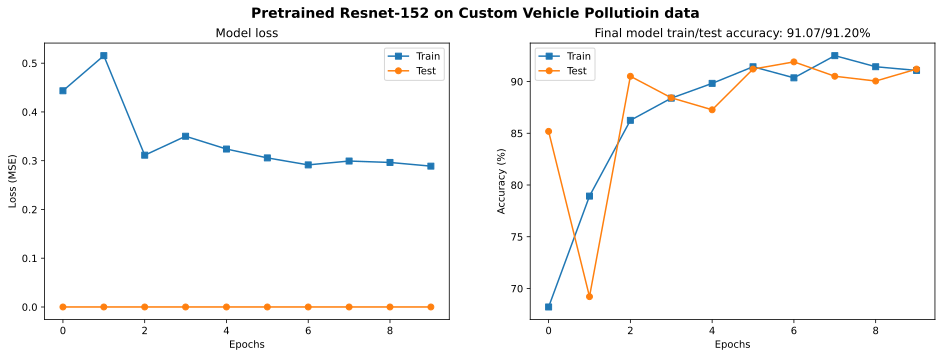

In [36]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained Resnet-152 on Custom Vehicle Pollutioin data',fontweight='bold',fontsize=14)

plt.show()




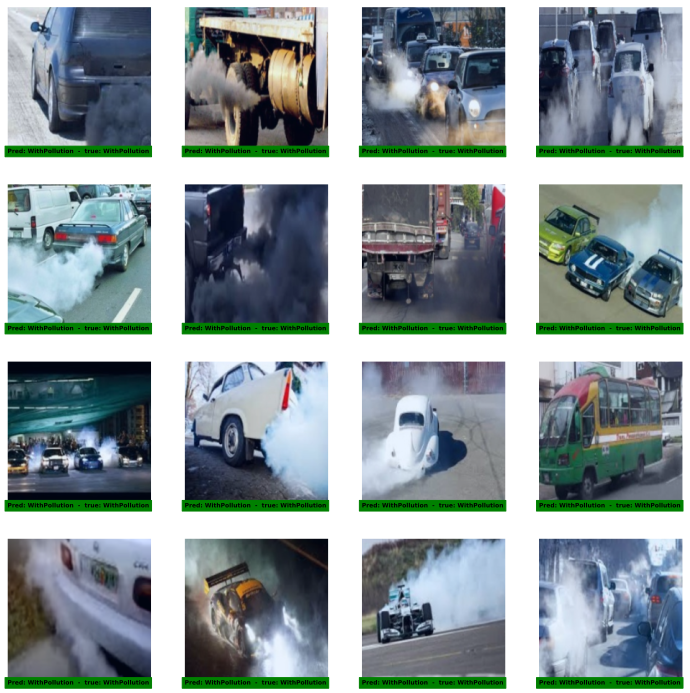

In [37]:
# inspect a few random images

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
resnet.eval()
predictions = torch.argmax( resnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  
  # show the image
  ax.imshow(pic)
  
  
  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(110,220,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=6)
  ax.axis('off')

plt.tight_layout()
plt.show()